In [44]:
import pandas as pd
import numpy as np
path = "https://raw.githubusercontent.com/allen1yuan/astro_data/main/datathon_2024_dataset.csv"
df = pd.read_csv(path)
df.drop(columns=df.columns[0], axis=1, inplace=True) # remove redundant index column

home_state = {'ARI': 'Phoenix AZ',
    'ATL': 'Atlanta GA',
    'BAL': 'Baltimore MD',
    'BOS': 'Boston MA',
    'CHN': 'Chicago IL',
    'CHA': 'Chicago IL',
    'CIN': 'Cincinnati OH',
    'CLE': 'Cleveland OH',
    'COL': 'Denver CO',
    'DET': 'Detroit MI',
    'HOU': 'Houston TX',
    'KCA': 'Kansas City MO',
    'ANA': 'Anaheim CA',
    'LAN': 'Los Angeles CA',
    'MIL': 'Milwaukee WI',
    'MIN': 'Minneapolis MN',
    'NYN': 'New York NY',
    'FLO': 'Miami FL',
    'MON': 'Montreal QUE',
    'NYA': 'New York NY',
    'OAK': 'Oakland CA',
    'PHI': 'Philadelphia PA',
    'PIT': 'Pittsburgh PA',
    'SDN': 'San Diego CA',
    'SFN': 'San Francisco CA',
    'SEA': 'Seattle WA',
    'SLN': 'St. Louis MO',
    'TBA': 'St. Petersburg FL',
    'TEX': 'Arlington TX',
    'TOR': 'Toronto ONT',
    'WAS': 'Washington DC',
    'MIA': 'Miami FL',
}

In [45]:
def is_home_game(row):
    team_abbr = row['home_team']
    game_city = row['city']

    return home_state.get(team_abbr, '').startswith(game_city)
df = df[df.apply(is_home_game, axis=1)]

In [46]:
df['home_win'] = (df['home_score'] > df['away_score']).astype(int)

In [69]:
df['away_positive_performance'] = df[['home_pa', 'home_1b', 'home_2b', 'home_3b', 'home_hr','home_fo', 'home_so']].sum(axis=1)
df['away_negtive_performance'] = df[['home_bb', 'home_hbp']].sum(axis=1)
df['away_overall_performance'] = df['home_positive_performance'] - df['home_negtive_performance']
df['home_positive_performance'] = df[['away_pa', 'away_1b', 'away_2b', 'away_3b', 'away_hr','away_fo', 'away_so']].sum(axis=1)
df['home_negative_performance'] = df[['away_bb', 'away_hbp']].sum(axis=1)
df['home_overall_performance'] = df['away_positive_performance'] - df['away_negative_performance']

In [70]:
bus_speed = 60  # in km/h
plane_speed = 800  # in km/h

df['away_team'] = df['away_team'].replace('FLO', 'MIA')
df['home_team'] = df['home_team'].replace('FLO', 'MIA')
df['away_team'] = df['away_team'].replace('MON', 'WAS')
df['home_team'] = df['home_team'].replace('MON', 'WAS')

def transport_mode(distance):
    return 'Plane' if distance > 563 else 'Bus'

def travel_time(distance, mode):
    speed = plane_speed if mode == 'Plane' else bus_speed
    return distance / speed

df['transport_mode'] = df['DistanceKM'].apply(transport_mode)
df['travel_time_hours'] = df.apply(lambda row: travel_time(row['DistanceKM'], row['transport_mode']), axis=1)

df

,game_date,home_team,away_team,Away City,Away City Latitude,Away City Longitude,is_day_game,home_score,away_score,venue,...,home_positive_performance,home_negtive_performance,home_overall_performance,away_positive_performance,away_negative_performance,away_overall_performance,transport_mode,travel_time_hours,away_negtive_performance,home_negative_performance
2,20000403,ATL,COL,Denver CO,39.739236,-104.984862,True,2,0,ATL02,...,62,2,64,66,2,64,Plane,2.437816,2,2
3,20000403,CIN,MIL,Milwaukee WI,43.034993,-87.922497,True,3,3,CIN08,...,39,5,48,49,1,44,Bus,8.705950,5,1
4,20000403,MIA,SFN,San Francisco CA,37.779026,-122.419906,False,6,4,MIA01,...,74,1,69,71,2,70,Plane,5.219369,1,2
5,20000403,WAS,LAN,Los Angeles CA,34.053691,-118.242766,False,4,10,MON02,...,74,4,80,82,2,78,Plane,4.968608,4,2
6,20000403,NYN,SDN,San Diego CA,32.717420,-117.162773,True,2,1,NYC17,...,57,1,62,65,3,64,Plane,4.894248,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56770,20231001,CHA,SDN,San Diego CA,32.717420,-117.162773,True,1,2,CHI12,...,84,7,77,81,4,74,Plane,3.490069,7,4
56771,20231001,DET,CLE,Cleveland OH,41.499657,-81.693677,True,5,2,DET05,...,70,1,61,67,6,66,Bus,2.422983,1,6
56772,20231001,KCA,NYA,New York NY,40.712728,-74.006015,True,5,2,KAN06,...,69,3,66,67,1,64,Plane,2.205178,3,1
56773,20231001,SEA,TEX,Arlington TX,32.735582,-97.107119,True,1,0,SEA03,...,58,0,58,60,2,60,Plane,3.360815,0,2


In [71]:
combined_data = df.copy()
combined_data.sort_values(by=['away_team', 'game_date'], inplace=True)

combined_data['away_team_traveled'] = 0

def detect_travel_modified(group):
    group = group.sort_values(by='game_date')

    group['prev_city'] = group['city'].shift(1)

    group['away_team_traveled'] = ((group['city'] != group['prev_city']) & group['prev_city'].notnull()).astype(int)

    group.drop('prev_city', axis=1, inplace=True)
    return group

combined_data = combined_data.groupby('away_team').apply(detect_travel_modified)

combined_data.reset_index(drop=True, inplace=True)

combined_data

,game_date,home_team,away_team,Away City,Away City Latitude,Away City Longitude,is_day_game,home_score,away_score,venue,...,home_negtive_performance,home_overall_performance,away_positive_performance,away_negative_performance,away_overall_performance,transport_mode,travel_time_hours,away_negtive_performance,home_negative_performance,away_team_traveled
0,20000414,CHA,ANA,Anaheim CA,33.834752,-117.911732,False,9,4,CHI12,...,1,74,77,3,76,Plane,3.492170,1,3,0
1,20000415,CHA,ANA,Anaheim CA,33.834752,-117.911732,True,1,3,CHI12,...,5,65,67,2,62,Plane,3.492170,5,2,0
2,20000416,CHA,ANA,Anaheim CA,33.834752,-117.911732,True,1,3,CHI12,...,3,75,77,2,74,Plane,3.492170,3,2,0
3,20000417,TOR,ANA,Anaheim CA,33.834752,-117.911732,False,7,1,TOR02,...,2,63,68,5,66,Plane,4.358403,2,5,1
4,20000418,TOR,ANA,Anaheim CA,33.834752,-117.911732,False,10,16,TOR02,...,10,98,100,2,90,Plane,4.358403,10,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56602,20230926,BAL,WAS,Washington DC,38.895037,-77.036543,False,1,0,BAL12,...,2,57,60,3,58,Bus,0.955700,2,3,1
56603,20230927,BAL,WAS,Washington DC,38.895037,-77.036543,False,5,1,BAL12,...,0,58,64,6,64,Bus,0.955700,0,6,0
56604,20230929,ATL,WAS,Washington DC,38.895037,-77.036543,False,6,10,ATL03,...,2,77,82,5,80,Plane,1.090540,2,5,1
56605,20230930,ATL,WAS,Washington DC,38.895037,-77.036543,False,5,3,ATL03,...,3,72,77,5,74,Plane,1.090540,3,5,0


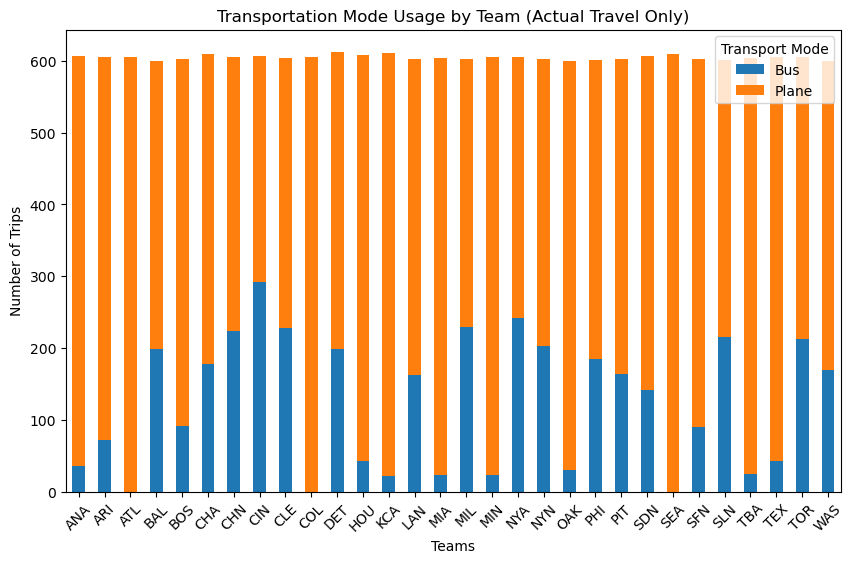

In [72]:
df_travel = combined_data[combined_data['away_team_traveled'] == 1]

# Count the number of bus and plane trips for each team
transport_counts = df_travel.groupby(['away_team', 'transport_mode']).size().unstack(fill_value=0)

transport_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Transportation Mode Usage by Team (Actual Travel Only)')
plt.xlabel('Teams')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.legend(title='Transport Mode')
plt.show()

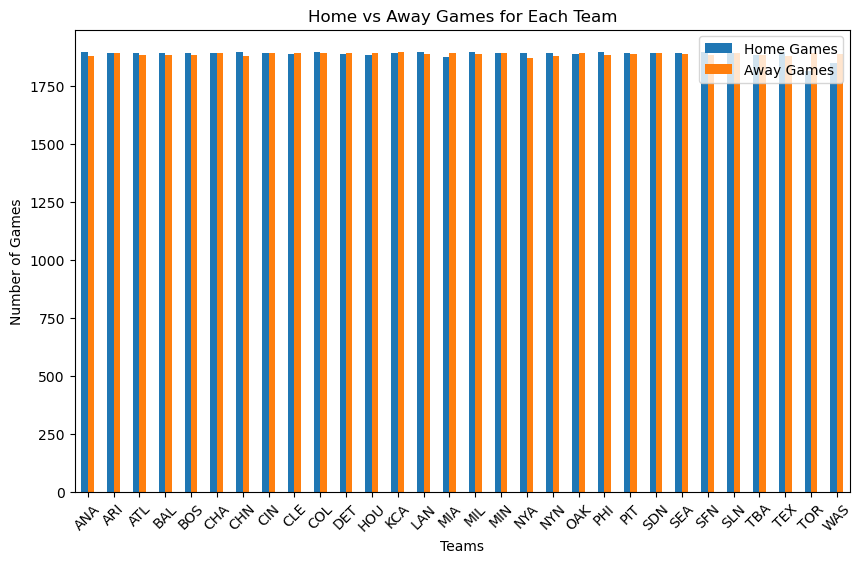

In [73]:
# Count home and away games for each team
home_games = combined_data['home_team'].value_counts()
away_games = combined_data['away_team'].value_counts()

game_counts = pd.DataFrame({'Home Games': home_games, 'Away Games': away_games}).fillna(0)

game_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Home vs Away Games for Each Team')
plt.xlabel('Teams')
plt.ylabel('Number of Games')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [74]:
from scipy.stats import chi2_contingency

def test_home_advantage(team, df):
    # Count home wins and losses
    home_games = combined_data[combined_data['home_team'] == team]
    home_wins = sum(home_games['home_win'])
    home_losses = len(home_games) - home_wins

    # Count away wins and losses
    away_games = combined_data[combined_data['away_team'] == team]
    away_wins = len(away_games) - sum(away_games['home_win'])
    away_losses = sum(away_games['home_win'])

    # Create contingency table
    table = [[home_wins, home_losses], [away_wins, away_losses]]

    # Perform Chi-Squared test
    chi2, p, _, _ = chi2_contingency(table)
    return chi2, p

teams = set(combined_data['home_team']).union(set(df['away_team']))
results = {team: test_home_advantage(team, df) for team in teams}

for team, (chi2, p) in results.items():
    print(f"Team: {team}, Chi-Squared: {chi2:.2f}, p-value: {p:.4f}")

Team: CHN, Chi-Squared: 17.91, p-value: 0.0000
Team: HOU, Chi-Squared: 22.31, p-value: 0.0000
Team: LAN, Chi-Squared: 20.81, p-value: 0.0000
Team: ATL, Chi-Squared: 13.19, p-value: 0.0003
Team: PHI, Chi-Squared: 19.98, p-value: 0.0000
Team: SDN, Chi-Squared: 17.91, p-value: 0.0000
Team: BOS, Chi-Squared: 11.79, p-value: 0.0006
Team: SFN, Chi-Squared: 24.06, p-value: 0.0000
Team: TOR, Chi-Squared: 23.06, p-value: 0.0000
Team: ARI, Chi-Squared: 18.15, p-value: 0.0000
Team: TBA, Chi-Squared: 34.64, p-value: 0.0000
Team: ANA, Chi-Squared: 15.21, p-value: 0.0001
Team: DET, Chi-Squared: 20.53, p-value: 0.0000
Team: MIA, Chi-Squared: 22.89, p-value: 0.0000
Team: BAL, Chi-Squared: 17.32, p-value: 0.0000
Team: WAS, Chi-Squared: 20.04, p-value: 0.0000
Team: NYN, Chi-Squared: 12.38, p-value: 0.0004
Team: MIL, Chi-Squared: 24.44, p-value: 0.0000
Team: CHA, Chi-Squared: 18.55, p-value: 0.0000
Team: MIN, Chi-Squared: 23.62, p-value: 0.0000
Team: CLE, Chi-Squared: 13.80, p-value: 0.0002
Team: COL, Ch

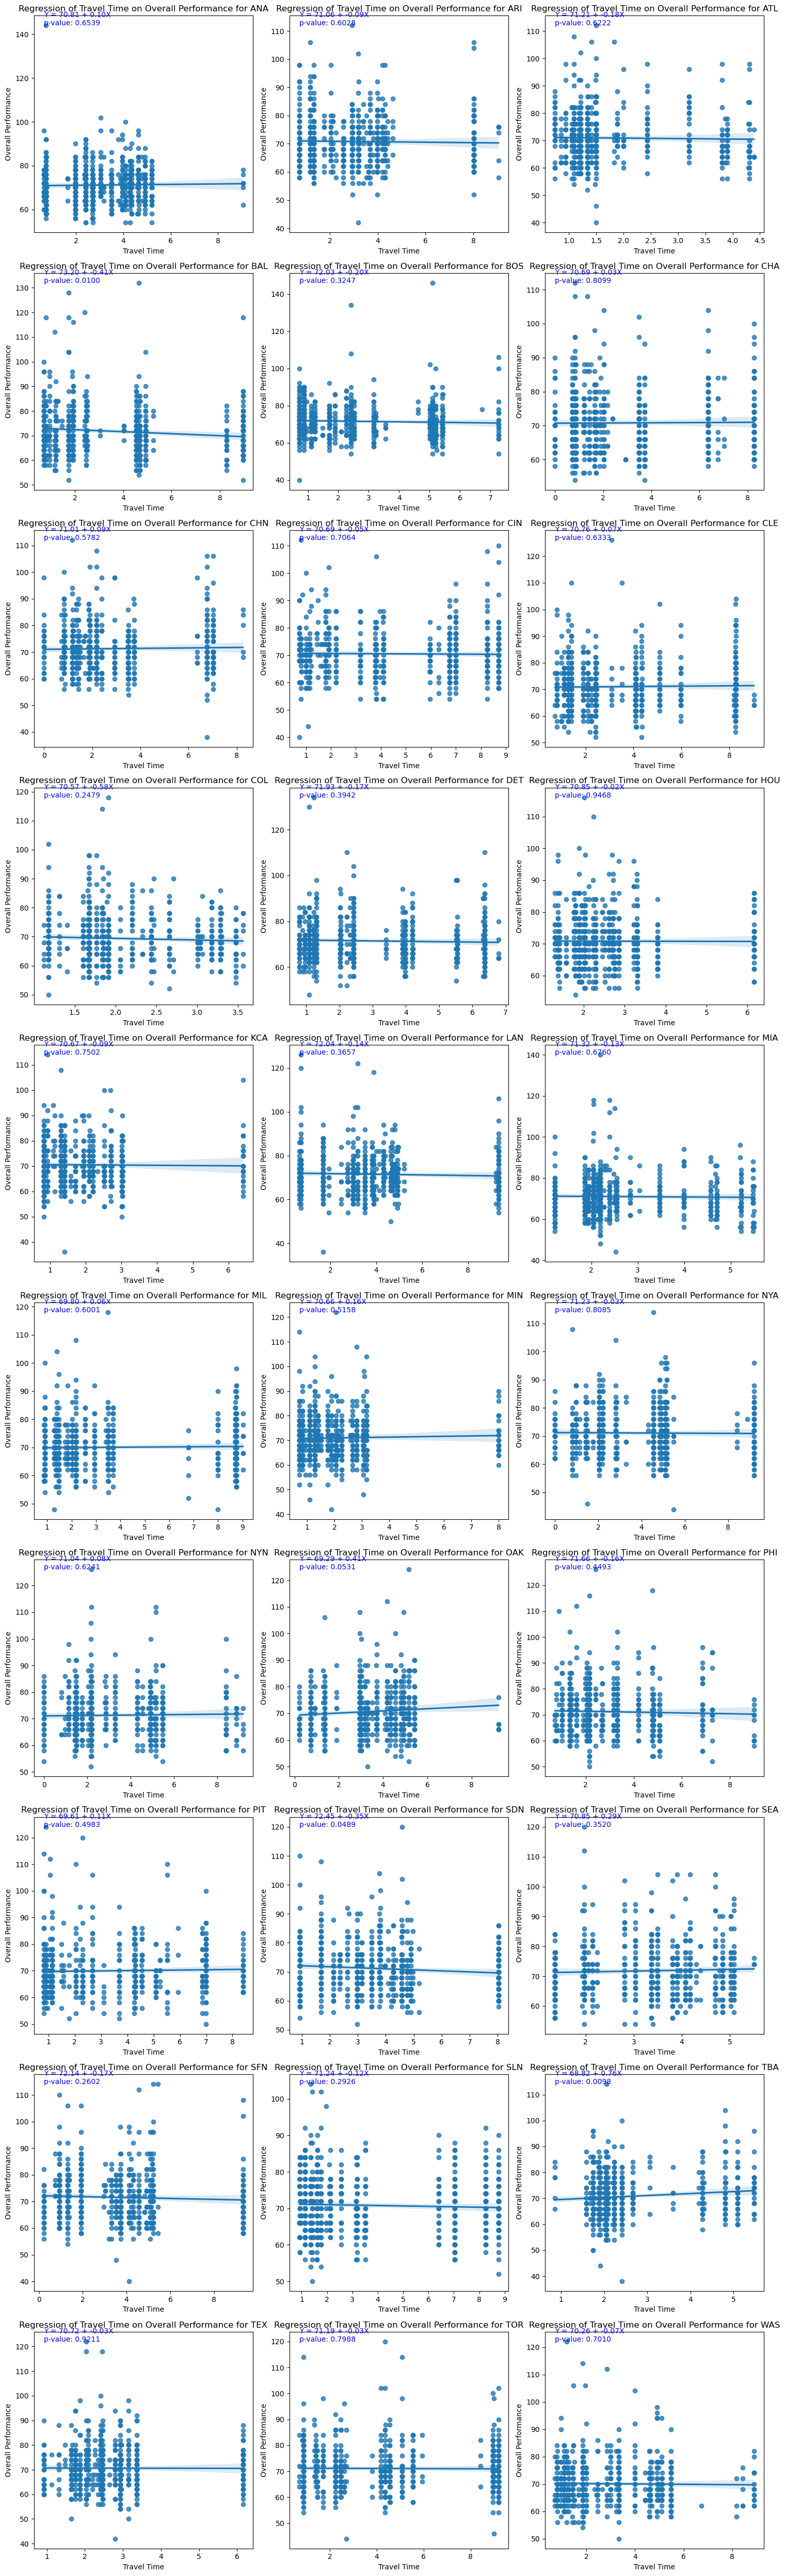

In [87]:
import seaborn as sns
teams = df_travel['away_team'].unique()
n_rows = math.ceil(len(teams) / 3)
n_cols = 3

plt.figure(figsize=(15, 5 * n_rows))

for i, team in enumerate(teams, 1):
    plt.subplot(n_rows, n_cols, i)
    team_df = df_travel[df_travel['away_team'] == team]
    
    X = team_df[['travel_time_hours']]
    y = team_df['away_overall_performance']

    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()
    
    intercept, slope = model.params
    
    sns.regplot(x='travel_time_hours', y='away_overall_performance', data=team_df)
    
    plt.title(f'Regression of Travel Time on Overall Performance for {team}')
    plt.xlabel('Travel Time')
    plt.ylabel('Overall Performance')
    
    plt.text(min(X['travel_time_hours']), max(y), f'Y = {intercept:.2f} + {slope:.2f}X\np-value: {model.pvalues[1]:.4f}', fontsize=10, color='blue')

plt.tight_layout()
plt.show()

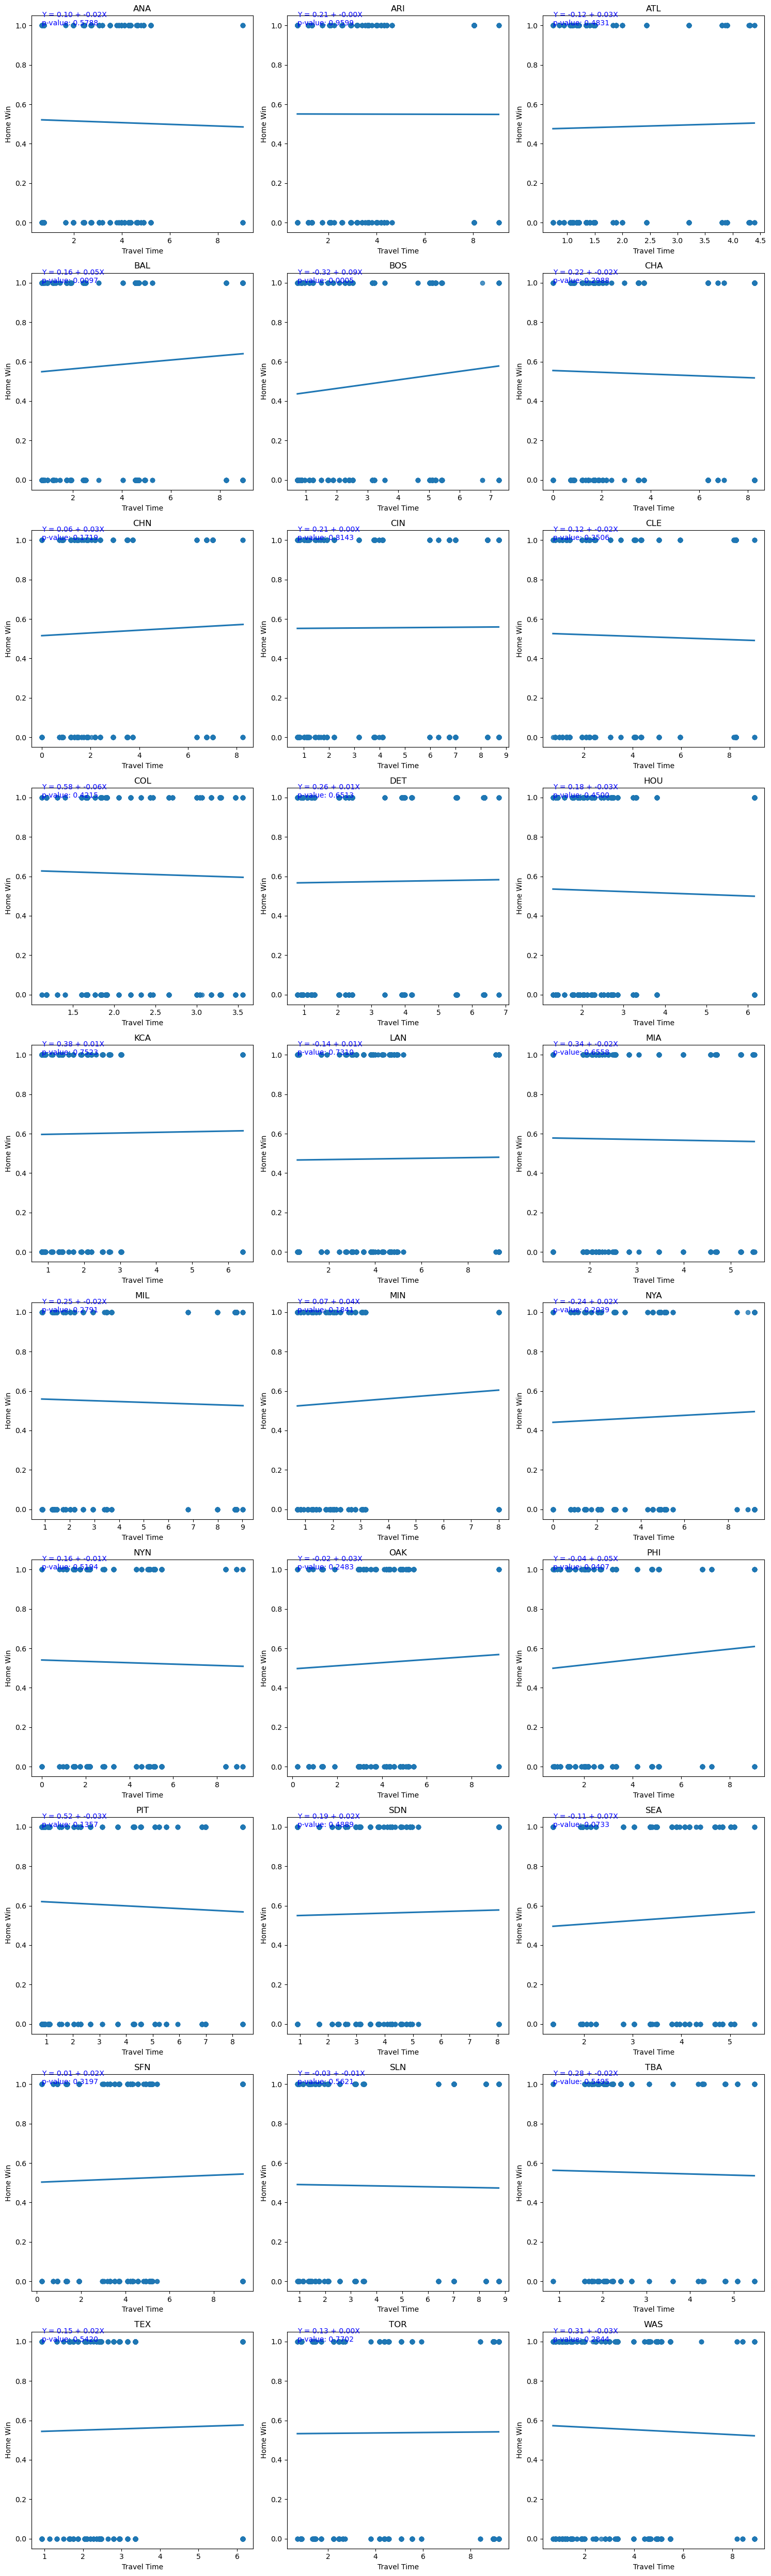

In [81]:
import math
n_rows = math.ceil(len(teams) / 3)
n_cols = 3

plt.figure(figsize=(15, 5 * n_rows))

for i, team in enumerate(teams, 1):
    plt.subplot(n_rows, n_cols, i)
    team_df = df[df['away_team'] == team]
    
    X = team_df[['travel_time_hours']]
    y = team_df['home_win']

    X = sm.add_constant(X)

    model = sm.Logit(y, X).fit(disp=0)
    
    intercept, slope = model.params

    sns.regplot(x='travel_time_hours', y='home_win', data=team_df, logistic=True, ci=None)

    plt.title(f'{team}')
    plt.xlabel('Travel Time')
    plt.ylabel('Home Win')

    plt.text(min(X['travel_time_hours']), max(y), f'Y = {intercept:.2f} + {slope:.2f}X\np-value: {model.pvalues[1]:.4f}', fontsize=10, color='blue')

plt.tight_layout()
plt.show()